In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
Rb85 = np.loadtxt("Rb85.txt",skiprows=1)
Rb87 = np.loadtxt("Rb87.txt",skiprows=1)
mixed_data = np.loadtxt("Rmixed.txt", skiprows = 1)


In [2]:
B_earth_NOAA = 44363.8e-9 *1e4
alpha = 2.799

In [3]:
def B_helmholtz(current_H):
    B_helmholtz =  (0.9e-6)*(135/27.5e-2)*current_H*1e4 # converted to Gauss
    return B_helmholtz

In [4]:
def findisotope(freq, B_H):

    B_ext = B_earth_NOAA + B_H # Gauss
    
    I = 2.799*(abs(B_ext)/(2*freq)) - 0.5
    print(I)
    heavy_residual = I - 3./2. # I Rb87 = 3/2
    light_residual = I - 5./2. # I Rb85 = 5/2
    for i in range(len(I)):
        if abs(heavy_residual[i]) < abs(light_residual[i]):
            I[i] = 3/2
        if abs(light_residual[i]) < abs(heavy_residual[i]):
            I[i] = 5/2
        else:
            I[i] = np.nan
    return I, heavy_residual, light_residual

In [5]:
def wls_getstats(x, y, w): #weighted_least_squares gives best fit line and its errors
    delta = np.sum(w)*np.sum(w*x**2) - (np.sum(w*x))**2
    intercept_errors = np.sqrt(np.sum((w*x**2))/delta)
    slope_errors = np.sqrt(np.sum(w)/delta)
    intercept = (np.sum(w*x**2)*np.sum(w*y) - np.sum(w*x)*np.sum(w*x*y))/delta
    slope = (np.sum(w)*np.sum(w*x*y) - np.sum(w*x)*np.sum(w*y))/delta
    f = lambda xs: slope*xs + intercept
    return f, slope, intercept, slope_errors, intercept_errors 

In [6]:
current_85 = Rb85[:,0]
maxfrequency85 = Rb85[:,1]
minfrequency85 = Rb85[:,2]
applied_B85 = B_helmholtz(current_85) # in Gauss
avgfrequency85 = 0.5*(maxfrequency85 + minfrequency85)
zipped85 = np.array([maxfrequency85, minfrequency85]) 



current_87 = Rb87[:,0]
applied_B87 = B_helmholtz(current_87)
maxfrequency87 = Rb87[:,1]
minfrequency87 = Rb87[:,2]
avgfrequency87 = 0.5*(maxfrequency87 + minfrequency87)
zipped87 = np.array([maxfrequency87, minfrequency87]) 


mixed_current = -1.*mixed_data[5:-5,0]
mixed_appliedB = B_helmholtz(mixed_current) 
mixed_maxfrequency = mixed_data[5:-5,1]
mixed_minfrequency = mixed_data[5:-5,2]
mixed_avgfrequency = 0.5*(mixed_maxfrequency + mixed_minfrequency)
mixed_zipped = np.array([mixed_maxfrequency, mixed_minfrequency])



index87 = mixed_avgfrequency> 2.4
applied_B85R = mixed_appliedB[~index87] 
applied_B87R = mixed_appliedB[index87]
avgfrequency87R = mixed_avgfrequency[index87]
avgfrequency85R = mixed_avgfrequency[~index87]

maxfrequency85R = mixed_maxfrequency[index87]
maxfrequency87R = mixed_maxfrequency[index87]
minfrequency85R = mixed_minfrequency[~index87]
minfrequency87R = mixed_minfrequency[index87] 
zipped85R = mixed_zipped[:,~index87]
zipped87R = mixed_zipped[:,index87]



fittedvalues_fwrd = np.linspace(-3, 4.35) # field values to calculate fitted frequencies at for forward case
fittedvalues_R= np.linspace(-4.35, 4.35) # field values to calculate fitted frequencies at


std_85 = np.std(zipped85, axis = 0) #std between two residence frequencuency 
weights_85 = 1/std_85
fit_85, slope_85, intercept_85, err_m_85, err_c_85 = wls_getstats(applied_B85, avgfrequency85, weights_85)
f_fit_85 = fit_85(fittedvalues_fwrd)


std_87 = np.std(zipped87, axis = 0) 
weights_87 = std_87**-1
fit_87, slope_87, intercept_87, err_m_87, err_c_87 = wls_getstats(applied_B87, avgfrequency87, weights_87)
f_fit_87 = fit_87(fittedvalues_fwrd)



std_85R = np.std(zipped85R, axis = 0) 
weights_85R = std_85R**-1
fit_85R, slope_85R, intercept_85R, err_m_85R, err_c_85R = wls_getstats(applied_B85R, avgfrequency85R, weights_85R)
f_fit_85R = fit_85R(fittedvalues_R)

std_87R = np.std(zipped87R, axis = 0) 
weights_87R = std_87R**-1
fit_87R, slope_87R, intercept_87R, err_m_87R, err_c_87R = wls_getstats(applied_B87R,avgfrequency87R, weights_87R)
f_fit_87R = fit_87R(fittedvalues_R)


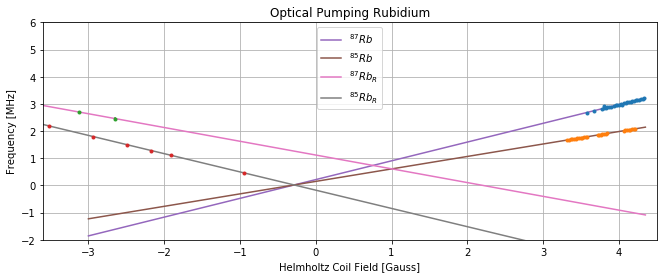

              Intercept  Error (+/-)
Rb85           0.148621     0.105012
Rb87           0.214840     0.209189
Rb85 Reverse  -0.173849     0.062229
Rb87 Reverse   1.118475     1.667277
                 Slope  Error (+/-)
Rb85          0.458729     0.027993
Rb87          0.690277     0.052395
Rb85 Reverse -0.671642     0.024165
Rb87 Reverse -0.506590     0.536583


In [7]:
plt.figure(figsize = [11,4])
plt.ylim([-2,6])
plt.xlim([-3.6,4.5])
plt.title('Optical Pumping Rubidium')


plt.errorbar(applied_B87, avgfrequency87, yerr = std_87, fmt = '.')
plt.errorbar(applied_B85, avgfrequency85, yerr = std_85, fmt = '.')
plt.errorbar(applied_B87R, avgfrequency87R, yerr = std_87R, fmt = '.')
plt.errorbar(applied_B85R, avgfrequency85R, yerr = std_85R, fmt = '.')

plt.plot(fittedvalues_fwrd, f_fit_87,label = ('$^{87}Rb$'))
plt.plot(fittedvalues_fwrd, f_fit_85,label = ('$^{85}Rb$'))
plt.plot(fittedvalues_R, f_fit_87R, label = ('$^{87}Rb_R$'))
plt.plot(fittedvalues_R, f_fit_85R, label =('$^{85}Rb_R$'))




plt.ylabel('Frequency [MHz]')
plt.xlabel('Helmholtz Coil Field [Gauss]')
plt.ylabel('Frequency [MHz]')
plt.xlabel('Helmholtz Coil Field [Gauss]')

plt.legend(fontsize=10)
plt.grid()
plt.show()





slopelist = [slope_85,slope_87,slope_85R,slope_87R]
errorlist = [err_m_85,err_m_87,err_m_85R,err_m_87R]
interceptlist = [intercept_85,intercept_87,intercept_85R,intercept_87R]
errorinterceptlist = [err_c_85,err_c_87,err_c_85R,err_c_87R]






dataslope = {"Slope": slopelist,'Error (+/-)':errorlist}


df_slope = pd.DataFrame(dataslope,index=['Rb85','Rb87','Rb85 Reverse','Rb87 Reverse'])

dataint = {"Intercept": interceptlist,'Error (+/-)':errorinterceptlist}
df_intercept = pd.DataFrame(dataint,index=['Rb85','Rb87','Rb85 Reverse','Rb87 Reverse'])

print(df_intercept)
print(df_slope)

In [8]:
#If f1/f2 = 1.5, then f1 corresponds to Rb87 and f2 with
f_ratios_F = avgfrequency87/avgfrequency85
print('Ratio of f1/f2: {:.4f} +/- {:.4f}'.format(np.mean(f_ratios_F),np.std(f_ratios_F)))

Ratio of f1/f2: 1.6117 +/- 0.0518


In [9]:
print('NOAA',48119.78e-9 *1e4,'Gauss')


NOAA 0.4811978 Gauss


In [10]:
def B_of_f(nu,I):
    alpha = 2.799
    Bb = (2*I + 1)*(nu/alpha)
    return Bb


estimate_Bearth_int85 = B_of_f(intercept_85, 2.5)
estimate_Bearth_int87 = B_of_f(intercept_87, 1.5)
# calculate errors:
err_estimate_Bearth_int85 = B_of_f(err_c_85, 2.5)
err_estimate_Bearth_int87 = B_of_f(err_c_87, 1.5)
# reverse: 
estimate_Bearth_int85R = B_of_f(intercept_85R, 2.5)
estimate_Bearth_int87R = B_of_f(intercept_87R, 1.5)
# calculate errors:
err_estimate_Bearth_int85R = B_of_f(err_c_85R, 2.5)
err_estimate_Bearth_int87R = B_of_f(err_c_87R, 1.5)
data_bint = {"Earths Magnetic Field from Intercepts": [estimate_Bearth_int85,estimate_Bearth_int87,estimate_Bearth_int85R,estimate_Bearth_int87R] ,'Error (+/-)':[err_estimate_Bearth_int85,err_estimate_Bearth_int87,err_estimate_Bearth_int85R,err_estimate_Bearth_int87R]}
df_data_bint = pd.DataFrame(data_bint,index=['Rb85','Rb87','Rb85 Reverse','Rb87 Reverse'])


print('B_earth estimate from y intercept')
df_data_bint

B_earth estimate from y intercept


,Earths Magnetic Field from Intercepts,Error (+/-)
Rb85,0.318587,0.225107
Rb87,0.307023,0.298949
Rb85 Reverse,-0.372667,0.133396
Rb87 Reverse,1.598393,2.382675


In [11]:
# weighted average:

B_earth_estimates = np.array([estimate_Bearth_int85, estimate_Bearth_int87, abs(estimate_Bearth_int85R)])
err_B_earth_estimates = np.array([err_estimate_Bearth_int85, err_estimate_Bearth_int87, err_estimate_Bearth_int85R]) #my arrays for erro and earth bfield
N = len(B_earth_estimates) #number of points
B_earth_best = np.sum(B_earth_estimates*err_B_earth_estimates**-1)/np.sum(err_B_earth_estimates**-1)
err_B_earth_best = np.sqrt(np.sum((B_earth_estimates - err_B_earth_estimates)**2*err_B_earth_estimates**-1)/np.sum((N-1/N)*err_B_earth_estimates**-1))
print('{:.4f} +/- {:,.4f}'.format(B_earth_best, err_B_earth_best))

0.3426 +/- 0.1072
